In [277]:
import torch.nn as nn
import wandb
import torch
import math
import time

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Set the default device for tensors
torch.cuda.set_device(0)  # Set the GPU you want to use if you have multiple GPUs


Using NVIDIA A100-SXM4-80GB


## Dataset Preparation

In [3]:
import pandas as pd
# Read Excel file into a Pandas DataFrame

df_cleaned = pd.read_csv("df_cleaned.csv")
df_cleaned

,chat,intensi
0,"Saya login siam bisa, disitu (atau tulisan ""Si...",gagal_login
1,Saya terhubung gagal terhubung VPN bisa menggu...,masalah_vpn
2,"Pak, Saya Dini Adriani, salah sejak Dosen LB B...",mengajukan_email
3,mau tanya menghubungkan padahal android vpn se...,masalah_vpn
4,"nya selalu gabisa min, muncul Vpn gambar",masalah_vpn
...,...,...
5107,"siang, Pada Kamis, 3 Maret 2022 kemarin mengik...",nilai_it_tidak_keluar
5108,"Min, Saya Izhar Yusuf Sadhana NIM. 17508060711...",nilai_it_tidak_keluar
5109,"Assalamualaikum, permisi, Saya: Nama : Mohamad...",nilai_it_tidak_keluar
5110,Ingin memperoleh informasi terkait nilai serti...,nilai_it_tidak_keluar


### Label Encoder

In [4]:
from sklearn.preprocessing import LabelEncoder

df = df_cleaned[['intensi','chat']]
le = LabelEncoder()
df['intensi'] = le.fit_transform(df['intensi'])
df.head()

,intensi,chat
0,1,"Saya login siam bisa, disitu (atau tulisan ""Si..."
1,2,Saya terhubung gagal terhubung VPN bisa menggu...
2,3,"Pak, Saya Dini Adriani, salah sejak Dosen LB B..."
3,2,mau tanya menghubungkan padahal android vpn se...
4,2,"nya selalu gabisa min, muncul Vpn gambar"


In [142]:
# Show the relationship between labels and numbers
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)

{'buat_reset_webhosting': 0, 'gagal_login': 1, 'masalah_vpn': 2, 'mengajukan_email': 3, 'nilai_it_tidak_keluar': 4, 'permintaan_lisensi_office': 5, 'ucapan_terima_kasih': 6}


In [219]:
labels = df['intensi']

### Tokenizing With Bert

In [214]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModel.from_pretrained("bert-base-multilingual-cased", output_hidden_states=True)

In [215]:
tokens = tokenizer.batch_encode_plus(df_cleaned['chat'].to_list(), return_tensors="pt", max_length=65,padding='max_length', truncation=True)

In [216]:
outputs = model(**tokens)
last_hidden_states = outputs.last_hidden_state
features = last_hidden_states.mean(dim=1)

### Data Splitting

In [220]:
from sklearn.model_selection import StratifiedShuffleSplit
features_np = features.detach().numpy()
labels_np = labels.to_numpy()

train_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_indices, val_indices = next(train_splitter.split(features_np, labels_np))
train_features, train_labels = features_np[train_indices], labels_np[train_indices]
val_features, val_labels = features_np[val_indices], labels_np[val_indices]

In [221]:
train_texts = df['chat'].iloc[train_indices].to_list()
val_texts = df['chat'].iloc[val_indices].to_list()

In [210]:
import numpy as np

np.savetxt('train_features.txt', train_features)
np.savetxt('train_labels.txt', train_labels)
np.savetxt('val_features.txt', val_features)
np.savetxt('val_labels.txt', val_labels)

In [222]:
print(len(train_features))
print(len(train_labels))
print(len(val_features))
print(len(val_labels))

4600
4600
512
512


### Data Loader

In [223]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, features, labels, texts):
        self.features = features
        self.labels = labels
        self.texts = texts
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.texts[idx]

In [224]:
import torch
from torch.utils.data import DataLoader

batch_size = 32
num_workers = 0

train_dataset = MyDataset(torch.Tensor(train_features), torch.Tensor(train_labels), train_texts)
val_dataset = MyDataset(torch.Tensor(val_features), torch.Tensor(val_labels), val_texts)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Training With Augmented Dataset

### LSTM

In [15]:
from torcheval.metrics.functional import multiclass_f1_score
import torch.optim as optim

In [16]:
class NaiveCustomLSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int, dropout_rate=0.0):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        self.dropout_rate = dropout_rate

        # Input gate parameters
        self.W_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))

        # Forget gate parameters
        self.W_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))

        # Cell gate parameters
        self.W_g = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_g = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_g = nn.Parameter(torch.Tensor(hidden_sz))

        # Output gate parameters
        self.W_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))

        # Dropout layer
        # self.dropout = nn.Dropout(dropout_rate)

        self.init_weights()

    def init_weights(self):
        # Initialize weights for LSTM gates
        for name, param in self.named_parameters():
            if 'W_' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'U_' in name:
                nn.init.orthogonal_(param.data)
            elif 'b_' in name:
                nn.init.zeros_(param.data)

    def forward(self, x, init_states=None):
        if x.dim() == 2:
            # Add a sequence dimension if it's not there
            x = x.unsqueeze(1)
        bs, seq_len, _ = x.size()

        if init_states is None:
            h_t, c_t = (
                torch.zeros(bs, self.hidden_size).to(x.device),
                torch.zeros(bs, self.hidden_size).to(x.device),
            )
        else:
            h_t, c_t = init_states

        outputs = []
        for t in range(seq_len):  # Loop over each timestep in the sequence
            x_t = x[:, t, :]  # Get input for the current timestep

            # LSTM cell computations
            f_t = torch.sigmoid(x_t @ self.W_f + h_t @ self.U_f + self.b_f)
            i_t = torch.sigmoid(x_t @ self.W_i + h_t @ self.U_i + self.b_i)
            g_t = torch.tanh(x_t @ self.W_g + h_t @ self.U_g + self.b_g)
            o_t = torch.sigmoid(x_t @ self.W_o + h_t @ self.U_o + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)

            outputs.append(h_t.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)  # Concatenate along the time dimension
        # Use only the final hidden state for classification
        final_output = outputs[:, -1, :]  # Shape: [batch_size, num_classes]
        return final_output



In [17]:
class LSTMNet(nn.Module):
    def __init__(self, hidden_sz):
        super().__init__()
        self.lstm = NaiveCustomLSTM(768, hidden_sz)  # Assuming NaiveCustomLSTM is correctly implemented
        self.fc1 = nn.Linear(hidden_sz, 7)
        # self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # Get the output from the LSTM
        h_n = self.lstm(x)  # h_n is the final hidden state

        # Apply dropout to the output of the LSTM
        # h_n = self.dropout(h_n)

        # Pass the output through the fully connected layer
        out = self.fc1(h_n)
        return out


In [18]:
LSTMclassifier = LSTMNet(64)
LSTMoptimizer = optim.Adam(LSTMclassifier.parameters(), lr=0.001, weight_decay=0.00017)
LSTMcriterion = nn.CrossEntropyLoss()
# wandb.watch(model, log="all")
# wandb.watch(LSTMclassifier, log="all")

In [19]:
import time

num_epochs = 20
LSTM_train_loss = []
LSTM_train_acc = []
LSTM_train_f1 = []
LSTM_val_loss = []
LSTM_val_acc = []
LSTM_val_f1 = []

for epoch in range(num_epochs):
    epoch_start = time.time()  # Start time of the epoch

    # Training phase
    running_loss = 0.0
    running_f1 = 0.0
    correct = 0
    total = 0
    model.train()
    for inputs, labels in train_loader:
        LSTMoptimizer.zero_grad()
        outputs = LSTMclassifier(inputs)
        loss = LSTMcriterion(outputs, labels.long())
        loss.backward()
        LSTMoptimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        running_f1 += multiclass_f1_score(predicted, labels, num_classes=7)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    epoch_f1 = running_f1 / len(train_loader)
    LSTM_train_loss.append(epoch_loss)
    LSTM_train_acc.append(epoch_acc)
    LSTM_train_f1.append(epoch_f1)

    # Validation phase
    valid_loss = 0.0
    valid_f1 = 0.0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = LSTMclassifier(inputs)
            loss = LSTMcriterion(outputs, labels.long())

            _, predicted = torch.max(outputs.data, 1)
            valid_f1 += multiclass_f1_score(predicted, labels, num_classes=7)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            valid_loss += loss.item()

    LSTM_val_loss.append(valid_loss / len(val_loader))
    LSTM_val_acc.append(correct / total)
    LSTM_val_f1.append(valid_f1 / len(val_loader))

    # Epoch end time
    epoch_end = time.time()
    epoch_duration = epoch_end - epoch_start

    # Print epoch summary
    print('Epoch [{}/{}], Time elapsed: {:.2f} s, \n\tTrain Loss: {:.4f}, Train Acc: {:.4f}, Train F1: {:.4f}'
          .format(epoch+1, num_epochs, epoch_duration, epoch_loss, epoch_acc, epoch_f1))
    print('\tVal Loss: {:.4f}, Val Acc: {:.4f}, Val F1: {:.4f}'
          .format(valid_loss / len(val_loader), correct / total, valid_f1 / len(val_loader)))

Epoch [1/20], Time elapsed: 76.89 s, 
	Train Loss: 0.8285, Train Acc: 0.7770, Train F1: 0.7772
	Val Loss: 0.2801, Val Acc: 0.9531, Val F1: 0.9531
Epoch [2/20], Time elapsed: 86.49 s, 
	Train Loss: 0.1931, Train Acc: 0.9672, Train F1: 0.9672
	Val Loss: 0.1361, Val Acc: 0.9766, Val F1: 0.9766
Epoch [3/20], Time elapsed: 85.83 s, 
	Train Loss: 0.1010, Train Acc: 0.9841, Train F1: 0.9842
	Val Loss: 0.0820, Val Acc: 0.9863, Val F1: 0.9863
Epoch [4/20], Time elapsed: 90.64 s, 
	Train Loss: 0.0641, Train Acc: 0.9904, Train F1: 0.9905
	Val Loss: 0.0620, Val Acc: 0.9922, Val F1: 0.9922
Epoch [5/20], Time elapsed: 88.78 s, 
	Train Loss: 0.0457, Train Acc: 0.9926, Train F1: 0.9926
	Val Loss: 0.0582, Val Acc: 0.9883, Val F1: 0.9883
Epoch [6/20], Time elapsed: 95.36 s, 
	Train Loss: 0.0344, Train Acc: 0.9959, Train F1: 0.9959
	Val Loss: 0.0420, Val Acc: 0.9902, Val F1: 0.9902
Epoch [7/20], Time elapsed: 93.55 s, 
	Train Loss: 0.0254, Train Acc: 0.9972, Train F1: 0.9972
	Val Loss: 0.0321, Val Acc: 0

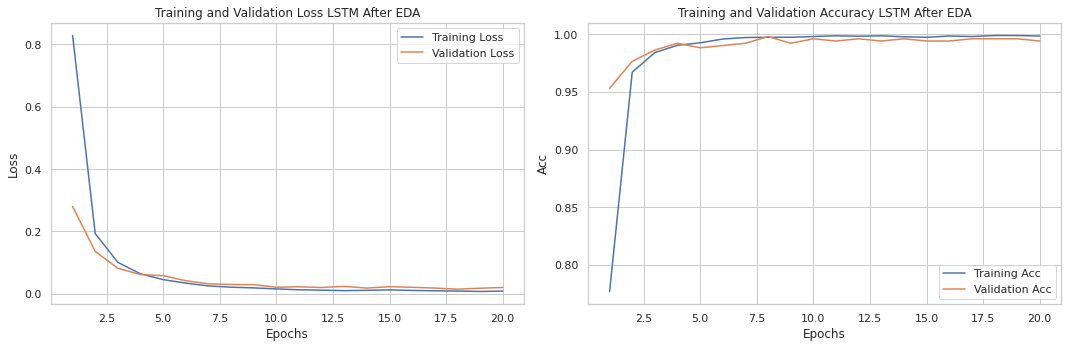

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
epochs = range(1, 21)

# Set Seaborn style
sns.set(style="whitegrid")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# First subplot: Training and Validation Loss
sns.lineplot(x=epochs, y=LSTM_train_loss, label='Training Loss', ax=ax1)
sns.lineplot(x=epochs, y=LSTM_val_loss, label='Validation Loss', ax=ax1)
ax1.set_title('Training and Validation Loss LSTM After EDA')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='best')

# Second subplot: Training and Validation Accuracy
sns.lineplot(x=epochs, y=LSTM_train_acc, label='Training Acc', ax=ax2)
sns.lineplot(x=epochs, y=LSTM_val_acc, label='Validation Acc', ax=ax2)
ax2.set_title('Training and Validation Accuracy LSTM After EDA')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Acc')
ax2.legend(loc='best')

# Adjust spacing between subplots
plt.tight_layout()

# Save the combined plot as an image file (e.g., PNG)
plt.savefig('plot/LSTM/LSTM_after.png')

# Show the combined plot
plt.show()


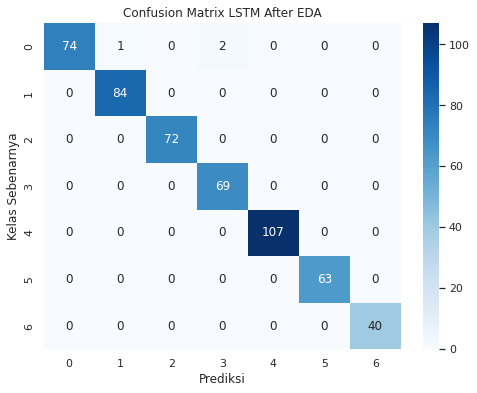

                           precision    recall  f1-score   support

    buat_reset_webhosting       1.00      0.96      0.98        77
              gagal_login       0.99      1.00      0.99        84
              masalah_vpn       1.00      1.00      1.00        72
         mengajukan_email       0.97      1.00      0.99        69
    nilai_it_tidak_keluar       1.00      1.00      1.00       107
permintaan_lisensi_office       1.00      1.00      1.00        63
      ucapan_terima_kasih       1.00      1.00      1.00        40

                 accuracy                           0.99       512
                macro avg       0.99      0.99      0.99       512
             weighted avg       0.99      0.99      0.99       512



In [167]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Set model ke mode evaluasi
LSTMclassifier.eval()

# Inisialisasi list untuk menyimpan label sebenarnya dan prediksi
y_true = []
y_pred = []

# Loop melalui data validasi dan mengumpulkan label sebenarnya dan prediksi
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = LSTMclassifier(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Menghitung confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Kelas Sebenarnya')
plt.title('Confusion Matrix LSTM After EDA')
plt.savefig('plot/LSTM/confusion_matrix_after.png')
plt.show()
plt.close()

# Menampilkan laporan klasifikasi
class_names = ['buat_reset_webhosting', 'gagal_login', 'masalah_vpn', 'mengajukan_email', 'nilai_it_tidak_keluar', 'permintaan_lisensi_office', 'ucapan_terima_kasih']  # Ganti dengan nama kelas Anda
print(classification_report(y_true, y_pred, target_names=class_names))

### GRU

In [23]:
class NaiveCustomGRU(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz

        # Update gate parameters
        self.W_z = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_z = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_z = nn.Parameter(torch.Tensor(hidden_sz))

        # Reset gate parameters
        self.W_r = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_r = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_r = nn.Parameter(torch.Tensor(hidden_sz))

        # New memory content parameters
        self.W_h = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_h = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_h = nn.Parameter(torch.Tensor(hidden_sz))

        self.init_weights()

    def init_weights(self):
        limit = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-limit, limit)

    def forward(self, x, init_state=None):
        if x.dim() == 2:
            # Add a sequence dimension if it's not there
            x = x.unsqueeze(1)
        # x is expected to be of shape [batch_size, sequence_length, input_size]
        bs, seq_len, _ = x.size()

        if init_state is None:
            h_t = torch.zeros(bs, self.hidden_size).to(x.device)
        else:
            h_t = init_state

        outputs = []
        for t in range(seq_len):  # Loop over each timestep in the sequence
            x_t = x[:, t, :]  # Get input for the current timestep

            # GRU cell computations
            z_t = torch.sigmoid(x_t @ self.W_z + h_t @ self.U_z + self.b_z)
            r_t = torch.sigmoid(x_t @ self.W_r + h_t @ self.U_r + self.b_r)
            h_tilde = torch.tanh(x_t @ self.W_h + (r_t * h_t) @ self.U_h + self.b_h)
            h_t = (1 - z_t) * h_t + z_t * h_tilde

            outputs.append(h_t.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)  # Concatenate along the time dimension
        return outputs, h_t  # Output and hidden state


In [24]:
class GRUNet(nn.Module):
    def __init__(self, hidden_sz):
        super().__init__()
        self.gru = NaiveCustomGRU(768, hidden_sz)  # Assuming input size is 768
        self.fc1 = nn.Linear(hidden_sz, 7)  # Assuming 7 is the number of classes
        # self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # Get the outputs and the final hidden state from the GRU
        outputs, h_n = self.gru(x)

        # Apply dropout to the final hidden state
        # h_n = self.dropout(h_n)

        # Pass the final hidden state through the fully connected layer
        x_ = self.fc1(h_n)
        return x_


In [25]:
# Example of creating the classifier, optimizer, and criterion
GRUclassifier = GRUNet(64)  # Hidden size of 64
GRUoptimizer = optim.Adam(GRUclassifier.parameters(), lr=0.001, weight_decay=0.00017)
GRUcriterion = nn.CrossEntropyLoss()

In [26]:
import time

num_epochs = 20
GRU_train_loss = []
GRU_train_acc = []
GRU_train_f1 = []
GRU_val_loss = []
GRU_val_acc = []
GRU_val_f1 = []

for epoch in range(num_epochs):
    epoch_start = time.time()  # Start time of the epoch

    # Training phase
    running_loss = 0.0
    running_f1 = 0.0
    correct = 0
    total = 0
    model.train()
    for inputs, labels in train_loader:
        GRUoptimizer.zero_grad()
        outputs = GRUclassifier(inputs)
        loss = GRUcriterion(outputs, labels.long())
        loss.backward()
        GRUoptimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        running_f1 += multiclass_f1_score(predicted, labels, num_classes=7)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    epoch_f1 = running_f1 / len(train_loader)
    GRU_train_loss.append(epoch_loss)
    GRU_train_acc.append(epoch_acc)
    GRU_train_f1.append(epoch_f1)

    # Validation phase
    valid_loss = 0.0
    valid_f1 = 0.0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = GRUclassifier(inputs)
            loss = GRUcriterion(outputs, labels.long())

            _, predicted = torch.max(outputs.data, 1)
            valid_f1 += multiclass_f1_score(predicted, labels, num_classes=7)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            valid_loss += loss.item()

    GRU_val_loss.append(valid_loss / len(val_loader))
    GRU_val_acc.append(correct / total)
    GRU_val_f1.append(valid_f1 / len(val_loader))

    # Calculate and print the epoch duration
    epoch_end = time.time()
    epoch_duration = epoch_end - epoch_start

    print('Epoch [{}/{}], Time elapsed: {:.2f} s, \n\tTrain Loss: {:.4f}, Train Acc: {:.4f}, Train F1: {:.4f}'
          .format(epoch+1, num_epochs, epoch_duration, epoch_loss, epoch_acc, epoch_f1))
    print('\tVal Loss: {:.4f}, Val Acc: {:.4f}, Val F1: {:.4f}'
          .format(valid_loss / len(val_loader), correct / total, valid_f1 / len(val_loader)))


Epoch [1/20], Time elapsed: 136.05 s, 
	Train Loss: 0.8200, Train Acc: 0.7870, Train F1: 0.7871
	Val Loss: 0.2793, Val Acc: 0.9492, Val F1: 0.9492
Epoch [2/20], Time elapsed: 144.29 s, 
	Train Loss: 0.1956, Train Acc: 0.9600, Train F1: 0.9600
	Val Loss: 0.1271, Val Acc: 0.9746, Val F1: 0.9746
Epoch [3/20], Time elapsed: 134.22 s, 
	Train Loss: 0.1005, Train Acc: 0.9839, Train F1: 0.9839
	Val Loss: 0.0742, Val Acc: 0.9844, Val F1: 0.9844
Epoch [4/20], Time elapsed: 145.35 s, 
	Train Loss: 0.0630, Train Acc: 0.9913, Train F1: 0.9913
	Val Loss: 0.0643, Val Acc: 0.9883, Val F1: 0.9883
Epoch [5/20], Time elapsed: 138.08 s, 
	Train Loss: 0.0432, Train Acc: 0.9943, Train F1: 0.9944
	Val Loss: 0.0420, Val Acc: 0.9902, Val F1: 0.9902
Epoch [6/20], Time elapsed: 143.47 s, 
	Train Loss: 0.0325, Train Acc: 0.9972, Train F1: 0.9972
	Val Loss: 0.0320, Val Acc: 0.9941, Val F1: 0.9941
Epoch [7/20], Time elapsed: 132.12 s, 
	Train Loss: 0.0266, Train Acc: 0.9963, Train F1: 0.9963
	Val Loss: 0.0305, Val

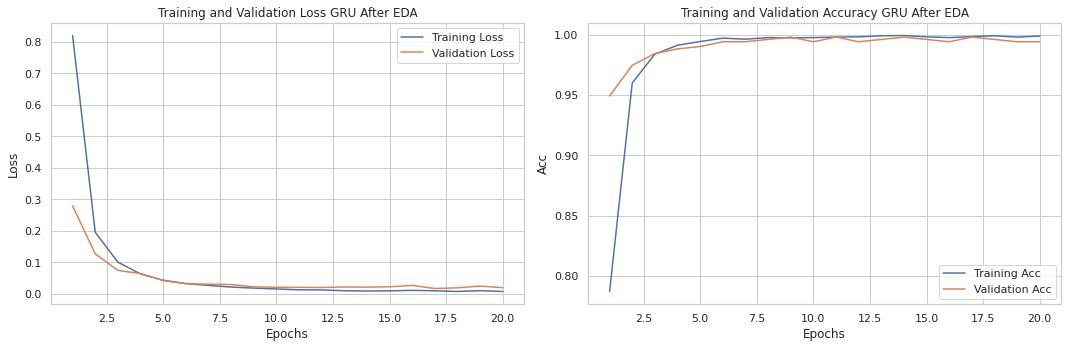

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
epochs = range(1, 21)

# Set Seaborn style
sns.set(style="whitegrid")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# First subplot: Training and Validation Loss
sns.lineplot(x=epochs, y=GRU_train_loss, label='Training Loss', ax=ax1)
sns.lineplot(x=epochs, y=GRU_val_loss, label='Validation Loss', ax=ax1)
ax1.set_title('Training and Validation Loss GRU After EDA')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='best')

# Second subplot: Training and Validation Accuracy
sns.lineplot(x=epochs, y=GRU_train_acc, label='Training Acc', ax=ax2)
sns.lineplot(x=epochs, y=GRU_val_acc, label='Validation Acc', ax=ax2)
ax2.set_title('Training and Validation Accuracy GRU After EDA')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Acc')
ax2.legend(loc='best')

# Adjust spacing between subplots
plt.tight_layout()

# Save the combined plot as an image file (e.g., PNG)
plt.savefig('plot/GRU/GRU_after.png')

# Show the combined plot
plt.show()


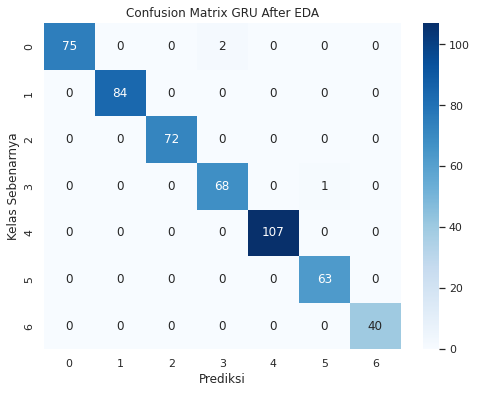

                           precision    recall  f1-score   support

    buat_reset_webhosting       1.00      0.97      0.99        77
              gagal_login       1.00      1.00      1.00        84
              masalah_vpn       1.00      1.00      1.00        72
         mengajukan_email       0.97      0.99      0.98        69
    nilai_it_tidak_keluar       1.00      1.00      1.00       107
permintaan_lisensi_office       0.98      1.00      0.99        63
      ucapan_terima_kasih       1.00      1.00      1.00        40

                 accuracy                           0.99       512
                macro avg       0.99      0.99      0.99       512
             weighted avg       0.99      0.99      0.99       512



In [168]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Set model ke mode evaluasi
GRUclassifier.eval()

# Inisialisasi list untuk menyimpan label sebenarnya dan prediksi
y_true = []
y_pred = []

# Loop melalui data validasi dan mengumpulkan label sebenarnya dan prediksi
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = GRUclassifier(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Menghitung confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Kelas Sebenarnya')
plt.title('Confusion Matrix GRU After EDA')
plt.savefig('plot/GRU/confusion_matrix_after.png')
plt.show()
plt.close()

# Menampilkan laporan klasifikasi
class_names = ['buat_reset_webhosting', 'gagal_login', 'masalah_vpn', 'mengajukan_email', 'nilai_it_tidak_keluar', 'permintaan_lisensi_office', 'ucapan_terima_kasih']  # Ganti dengan nama kelas Anda
print(classification_report(y_true, y_pred, target_names=class_names))

### RNN

In [29]:
class NaiveCustomRNN(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int, dropout_rate=0.0):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        self.dropout_rate = dropout_rate

        # Weights for input to hidden transformation
        self.W_h = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        # Weights for hidden to hidden transformation
        self.U_h = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        # Bias
        self.b_h = nn.Parameter(torch.Tensor(hidden_sz))
        # self.fc = nn.Linear(hidden_sz, output_size)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        self.init_weights()

    def init_weights(self):
        # Xavier (Glorot) initialization for input to hidden weights
        nn.init.xavier_uniform_(self.W_h)
        
        # Orthogonal initialization for hidden to hidden weights
        nn.init.orthogonal_(self.U_h)
        
        # Zero initialization for biases
        nn.init.zeros_(self.b_h)
        
        # Xavier (Glorot) initialization for fully connected layer
        # nn.init.xavier_uniform_(self.fc.weight)
        # nn.init.zeros_(self.fc.bias)

    def forward(self, x, init_state=None):
        if x.dim() == 2:
            # Add a sequence dimension if it's not there
            x = x.unsqueeze(1)
        bs, seq_len, _ = x.size()

        if init_state is None:
            h_t = torch.zeros(bs, self.hidden_size).to(x.device)
        else:
            h_t = init_state

        hidden_states = []
        
        for t in range(seq_len):  # Loop over each timestep in the sequence
            x_t = x[:, t, :]  # x_t is [batch_size, input_size]
            h_t = torch.tanh(x_t @ self.W_h + h_t @ self.U_h + self.b_h)
            h_t = self.dropout(h_t)
            hidden_states.append(h_t.unsqueeze(1))

        hidden_states = torch.cat(hidden_states, dim=1)

        last_hidden_state = hidden_states[:, -1, :] 
        # output = self.fc(last_hidden_state)
        return last_hidden_state


In [30]:
class RNNNet(nn.Module):
    def __init__(self, hidden_sz):
        super().__init__()
        self.rnn = NaiveCustomRNN(768, hidden_sz)  # No output_size needed
        self.fc1 = nn.Linear(hidden_sz, 7)  # Number of classes as output size

    def forward(self, x):
        x_ = self.rnn(x)  # x_ is now just the output tensor
        x_ = self.fc1(x_)
        return x_


In [31]:
# Example of creating the classifier, optimizer, and criterion
RNNclassifier = RNNNet(64)  # Hidden size of 64
RNNoptimizer = optim.Adam(RNNclassifier.parameters(), lr=0.001, weight_decay=0.00017)
RNNcriterion = nn.CrossEntropyLoss()

In [32]:
import time

num_epochs = 20
RNN_train_loss = []
RNN_train_acc = []
RNN_train_f1 = []
RNN_val_loss = []
RNN_val_acc = []
RNN_val_f1 = []

for epoch in range(num_epochs):
    epoch_start = time.time()  # Start time of the epoch

    # Training phase
    running_loss = 0.0
    running_f1 = 0.0
    correct = 0
    total = 0
    model.train()
    for inputs, labels in train_loader:
        RNNoptimizer.zero_grad()
        outputs = RNNclassifier(inputs)
        loss = RNNcriterion(outputs, labels.long())
        loss.backward()
        RNNoptimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        running_f1 += multiclass_f1_score(predicted, labels, num_classes=7)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    epoch_f1 = running_f1 / len(train_loader)
    RNN_train_loss.append(epoch_loss)
    RNN_train_acc.append(epoch_acc)
    RNN_train_f1.append(epoch_f1)

    # Validation phase
    valid_loss = 0.0
    valid_f1 = 0.0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = RNNclassifier(inputs)
            loss = RNNcriterion(outputs, labels.long())

            _, predicted = torch.max(outputs.data, 1)
            valid_f1 += multiclass_f1_score(predicted, labels, num_classes=7)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            valid_loss += loss.item()

    RNN_val_loss.append(valid_loss / len(val_loader))
    RNN_val_acc.append(correct / total)
    RNN_val_f1.append(valid_f1 / len(val_loader))

    # Epoch end time and duration
    epoch_end = time.time()
    epoch_duration = epoch_end - epoch_start

    # Print epoch summary with time elapsed
    print('Epoch [{}/{}], Time elapsed: {:.2f} s, \n\tTrain Loss: {:.4f}, Train Acc: {:.4f}, Train F1: {:.4f}'
          .format(epoch+1, num_epochs, epoch_duration, epoch_loss, epoch_acc, epoch_f1))
    print('\tVal Loss: {:.4f}, Val Acc: {:.4f}, Val F1: {:.4f}'
          .format(valid_loss / len(val_loader), correct / total, valid_f1 / len(val_loader)))


Epoch [1/20], Time elapsed: 75.72 s, 
	Train Loss: 0.7945, Train Acc: 0.8020, Train F1: 0.8021
	Val Loss: 0.2982, Val Acc: 0.9395, Val F1: 0.9395
Epoch [2/20], Time elapsed: 87.23 s, 
	Train Loss: 0.2125, Train Acc: 0.9574, Train F1: 0.9575
	Val Loss: 0.1356, Val Acc: 0.9766, Val F1: 0.9766
Epoch [3/20], Time elapsed: 87.42 s, 
	Train Loss: 0.1099, Train Acc: 0.9811, Train F1: 0.9810
	Val Loss: 0.0921, Val Acc: 0.9824, Val F1: 0.9824
Epoch [4/20], Time elapsed: 56.11 s, 
	Train Loss: 0.0715, Train Acc: 0.9885, Train F1: 0.9885
	Val Loss: 0.0682, Val Acc: 0.9863, Val F1: 0.9863
Epoch [5/20], Time elapsed: 54.99 s, 
	Train Loss: 0.0498, Train Acc: 0.9924, Train F1: 0.9924
	Val Loss: 0.0437, Val Acc: 0.9922, Val F1: 0.9922
Epoch [6/20], Time elapsed: 69.31 s, 
	Train Loss: 0.0346, Train Acc: 0.9952, Train F1: 0.9952
	Val Loss: 0.0474, Val Acc: 0.9902, Val F1: 0.9902
Epoch [7/20], Time elapsed: 90.26 s, 
	Train Loss: 0.0295, Train Acc: 0.9957, Train F1: 0.9957
	Val Loss: 0.0342, Val Acc: 0

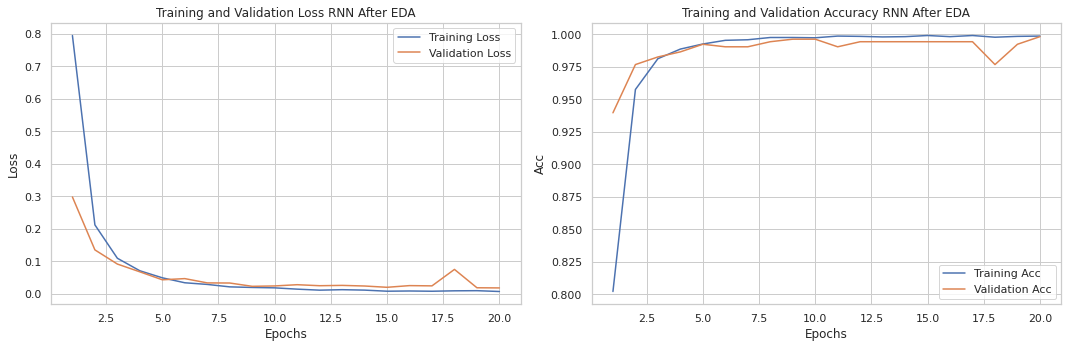

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
epochs = range(1, 21)

# Set Seaborn style
sns.set(style="whitegrid")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# First subplot: Training and Validation Loss
sns.lineplot(x=epochs, y=RNN_train_loss, label='Training Loss', ax=ax1)
sns.lineplot(x=epochs, y=RNN_val_loss, label='Validation Loss', ax=ax1)
ax1.set_title('Training and Validation Loss RNN After EDA')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='best')

# Second subplot: Training and Validation Accuracy
sns.lineplot(x=epochs, y=RNN_train_acc, label='Training Acc', ax=ax2)
sns.lineplot(x=epochs, y=RNN_val_acc, label='Validation Acc', ax=ax2)
ax2.set_title('Training and Validation Accuracy RNN After EDA')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Acc')
ax2.legend(loc='best')

# Adjust spacing between subplots
plt.tight_layout()

# Save the combined plot as an image file (e.g., PNG)
plt.savefig('plot/RNN/RNN_after.png')

# Show the combined plot
plt.show()


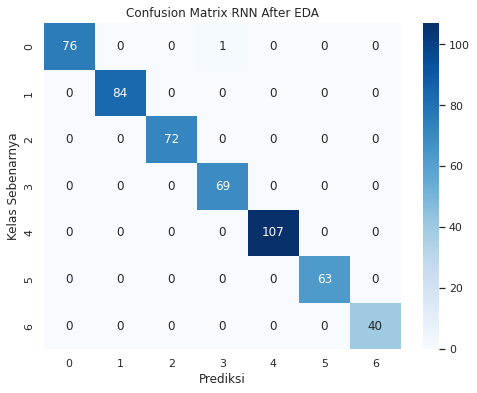

                           precision    recall  f1-score   support

    buat_reset_webhosting       1.00      0.99      0.99        77
              gagal_login       1.00      1.00      1.00        84
              masalah_vpn       1.00      1.00      1.00        72
         mengajukan_email       0.99      1.00      0.99        69
    nilai_it_tidak_keluar       1.00      1.00      1.00       107
permintaan_lisensi_office       1.00      1.00      1.00        63
      ucapan_terima_kasih       1.00      1.00      1.00        40

                 accuracy                           1.00       512
                macro avg       1.00      1.00      1.00       512
             weighted avg       1.00      1.00      1.00       512



In [169]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Set model ke mode evaluasi
RNNclassifier.eval()

# Inisialisasi list untuk menyimpan label sebenarnya dan prediksi
y_true = []
y_pred = []

# Loop melalui data validasi dan mengumpulkan label sebenarnya dan prediksi
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = RNNclassifier(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Menghitung confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Kelas Sebenarnya')
plt.title('Confusion Matrix RNN After EDA')
plt.savefig('plot/RNN/confusion_matrix_after.png')
plt.show()
plt.close()

# Menampilkan laporan klasifikasi
class_names = ['buat_reset_webhosting', 'gagal_login', 'masalah_vpn', 'mengajukan_email', 'nilai_it_tidak_keluar', 'permintaan_lisensi_office', 'ucapan_terima_kasih']  # Ganti dengan nama kelas Anda
print(classification_report(y_true, y_pred, target_names=class_names))

## Training With Dataset Before Augmentation

### Data Preparation

In [39]:
df_before = pd.read_excel("Data/Rekap Dataset-v0.3.xlsx")
df_before

,no,intensi,chat,thread_id,entitas
0,1.0,gagal_login,"Saya login siam tetapi tidak bisa, disitu tere...",11.0,aplikasi:siam
1,2.0,masalah_vpn,Saya tidak bisa terhubung/gagal terhubung deng...,48.0,aplikasi:VPN UB
2,3.0,mengajukan_email,"Selamat sore Pak,<br />Saya Dini Adriani, sala...",54.0,orang:Dini Adriani|organisasi:BIPA;LIH FIB UB
3,4.0,masalah_vpn,assalamualaikum <br />saya mau tanya kenapa sa...,104.0,aplikasi:vpn ub
4,5.0,masalah_vpn,"Vpn nya selalu gabisa min, muncul seperti di g...",197.0,aplikasi:vpn
...,...,...,...,...,...
702,663.0,nilai_it_tidak_keluar,"<p>Selamat Sore Min, Saya Izhar Yusuf Sadhana ...",NaN,orang:Izhar Yusuf Sadhana|organisasi:Prodi IK
703,664.0,nilai_it_tidak_keluar,"<p>Assalamualaikum, permisi, Saya:</p> <p>Nama...",NaN,orang:Mohamad Iqbal Septian Hamdany
704,665.0,nilai_it_tidak_keluar,<p>Ingin memperoleh informasi terkait nilai da...,NaN,NaN
705,666.0,nilai_it_tidak_keluar,<p>Selamat siang saya Siska Silvia Iindarwati ...,NaN,orang:Siska Silvia Iindarwati


In [40]:
df_before_fix = df_before[['intensi','chat']]
df_before_fix['intensi'] = le.fit_transform(df_before_fix['intensi'])
df_before_fix.head()

/tmp/ipykernel_19368/1534074812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_before_fix['intensi'] = le.fit_transform(df_before_fix['intensi'])


,intensi,chat
0,1,"Saya login siam tetapi tidak bisa, disitu tere..."
1,2,Saya tidak bisa terhubung/gagal terhubung deng...
2,3,"Selamat sore Pak,<br />Saya Dini Adriani, sala..."
3,2,assalamualaikum <br />saya mau tanya kenapa sa...
4,2,"Vpn nya selalu gabisa min, muncul seperti di g..."


In [41]:
labels_before = df_before_fix['intensi']

In [118]:
tokenizer_before = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model_before = AutoModel.from_pretrained("bert-base-multilingual-cased", output_hidden_states=True)

In [119]:
tokens_before = tokenizer_before.batch_encode_plus(df_before_fix['chat'].to_list(), return_tensors="pt", max_length=65,padding='max_length', truncation=True)

In [120]:
outputs_before = model_before(**tokens_before)
last_hidden_states_before = outputs_before.last_hidden_state
features_before = last_hidden_states_before.mean(dim=1)

In [121]:
features_np_before = features_before.detach().numpy()
labels_np_before = labels_before.to_numpy()

train_splitter_before = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_indices_before, val_indices_before = next(train_splitter_before.split(features_np_before, labels_np_before))
train_features_before, train_labels_before = features_np_before[train_indices_before], labels_np_before[train_indices_before]
val_features_before, val_labels_before = features_np_before[val_indices_before], labels_np_before[val_indices_before]

In [122]:
print(len(train_features_before))
print(len(train_labels_before))
print(len(val_features_before))
print(len(val_labels_before))

636
636
71
71


In [123]:
train_dataset_before = MyDataset(torch.Tensor(train_features_before), torch.Tensor(train_labels_before))
val_dataset_before = MyDataset(torch.Tensor(val_features_before), torch.Tensor(val_labels_before))

batch_size = 32
num_workers = 0

train_loader_before = DataLoader(train_dataset_before, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader_before = DataLoader(val_dataset_before, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### LSTM

In [124]:
LSTMclassifier_before = LSTMNet(64)
LSTMoptimizer_before = optim.Adam(LSTMclassifier_before.parameters(), lr=0.001, weight_decay=0.00017)
LSTMcriterion_before = nn.CrossEntropyLoss()

In [125]:
import time

num_epochs = 20
LSTM_train_loss_before = []
LSTM_train_acc_before = []
LSTM_train_f1_before = []
LSTM_val_loss_before = []
LSTM_val_acc_before = []
LSTM_val_f1_before = []

for epoch in range(num_epochs):
    epoch_start = time.time()  # Start time of the epoch

    # Training phase
    running_loss = 0.0
    running_f1 = 0.0
    correct = 0
    total = 0
    model_before.train()
    for inputs, labels in train_loader_before:
        LSTMoptimizer_before.zero_grad()
        outputs = LSTMclassifier_before(inputs)
        loss = LSTMcriterion_before(outputs, labels.long())
        loss.backward()
        LSTMoptimizer_before.step()

        _, predicted = torch.max(outputs.data, 1)
        running_f1 += multiclass_f1_score(predicted, labels, num_classes=7)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader_before)
    epoch_acc = correct / total
    epoch_f1 = running_f1 / len(train_loader_before)
    LSTM_train_loss_before.append(epoch_loss)
    LSTM_train_acc_before.append(epoch_acc)
    LSTM_train_f1_before.append(epoch_f1)

    # Validation phase
    valid_loss = 0.0
    valid_f1 = 0.0
    correct = 0
    total = 0
    model_before.eval()
    with torch.no_grad():
        for inputs, labels in val_loader_before:
            outputs = LSTMclassifier_before(inputs)
            loss = LSTMcriterion_before(outputs, labels.long())

            _, predicted = torch.max(outputs.data, 1)
            valid_f1 += multiclass_f1_score(predicted, labels, num_classes=7)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            valid_loss += loss.item()

    LSTM_val_loss_before.append(valid_loss / len(val_loader_before))
    LSTM_val_acc_before.append(correct / total)
    LSTM_val_f1_before.append(valid_f1 / len(val_loader_before))

    # Epoch end time
    epoch_end = time.time()
    epoch_duration = epoch_end - epoch_start

    # Print epoch summary
    print('Epoch [{}/{}], Time elapsed: {:.2f} s, \n\tTrain Loss: {:.4f}, Train Acc: {:.4f}, Train F1: {:.4f}'
          .format(epoch+1, num_epochs, epoch_duration, epoch_loss, epoch_acc, epoch_f1))
    print('\tVal Loss: {:.4f}, Val Acc: {:.4f}, Val F1: {:.4f}'
          .format(valid_loss / len(val_loader_before), correct / total, valid_f1 / len(val_loader_before)))

Epoch [1/20], Time elapsed: 15.25 s, 
	Train Loss: 1.7815, Train Acc: 0.3695, Train F1: 0.3714
	Val Loss: 1.5951, Val Acc: 0.5352, Val F1: 0.5818
Epoch [2/20], Time elapsed: 14.90 s, 
	Train Loss: 1.3434, Train Acc: 0.6415, Train F1: 0.6417
	Val Loss: 1.2269, Val Acc: 0.6479, Val F1: 0.6652
Epoch [3/20], Time elapsed: 10.51 s, 
	Train Loss: 0.9845, Train Acc: 0.7799, Train F1: 0.7801
	Val Loss: 0.9953, Val Acc: 0.7042, Val F1: 0.6696
Epoch [4/20], Time elapsed: 10.68 s, 
	Train Loss: 0.7581, Train Acc: 0.8333, Train F1: 0.8337
	Val Loss: 0.8351, Val Acc: 0.7887, Val F1: 0.7321
Epoch [5/20], Time elapsed: 10.14 s, 
	Train Loss: 0.6014, Train Acc: 0.8774, Train F1: 0.8775
	Val Loss: 0.7575, Val Acc: 0.7746, Val F1: 0.7217
Epoch [6/20], Time elapsed: 10.15 s, 
	Train Loss: 0.4963, Train Acc: 0.8884, Train F1: 0.8884
	Val Loss: 0.6478, Val Acc: 0.8592, Val F1: 0.8214
Epoch [7/20], Time elapsed: 12.15 s, 
	Train Loss: 0.4141, Train Acc: 0.9182, Train F1: 0.9187
	Val Loss: 0.6310, Val Acc: 0

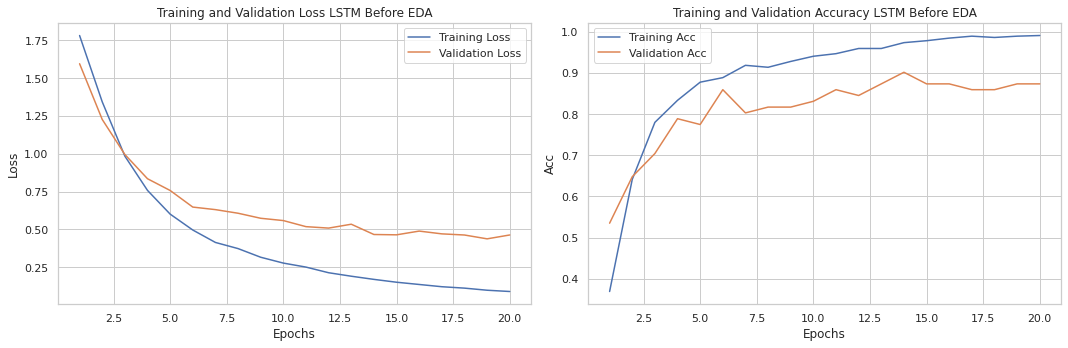

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
epochs = range(1, 21)

# Set Seaborn style
sns.set(style="whitegrid")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# First subplot: Training and Validation Loss
sns.lineplot(x=epochs, y=LSTM_train_loss_before, label='Training Loss', ax=ax1)
sns.lineplot(x=epochs, y=LSTM_val_loss_before, label='Validation Loss', ax=ax1)
ax1.set_title('Training and Validation Loss LSTM Before EDA')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='best')

# Second subplot: Training and Validation Accuracy
sns.lineplot(x=epochs, y=LSTM_train_acc_before, label='Training Acc', ax=ax2)
sns.lineplot(x=epochs, y=LSTM_val_acc_before, label='Validation Acc', ax=ax2)
ax2.set_title('Training and Validation Accuracy LSTM Before EDA')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Acc')
ax2.legend(loc='best')

# Adjust spacing between subplots
plt.tight_layout()

# Save the combined plot as an image file (e.g., PNG)
plt.savefig('plot/LSTM/LSTM_before.png')

# Show the combined plot
plt.show()


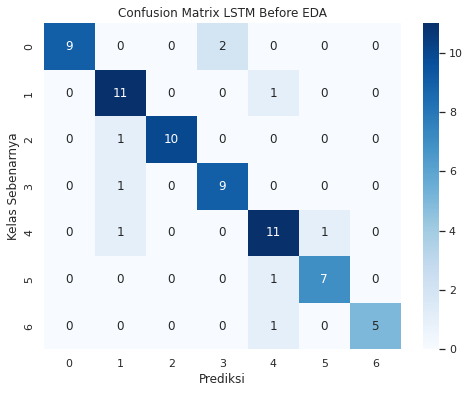

                           precision    recall  f1-score   support

    buat_reset_webhosting       1.00      0.82      0.90        11
              gagal_login       0.79      0.92      0.85        12
              masalah_vpn       1.00      0.91      0.95        11
         mengajukan_email       0.82      0.90      0.86        10
    nilai_it_tidak_keluar       0.79      0.85      0.81        13
permintaan_lisensi_office       0.88      0.88      0.88         8
      ucapan_terima_kasih       1.00      0.83      0.91         6

                 accuracy                           0.87        71
                macro avg       0.89      0.87      0.88        71
             weighted avg       0.88      0.87      0.88        71



In [166]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Set model ke mode evaluasi
LSTMclassifier_before.eval()

# Inisialisasi list untuk menyimpan label sebenarnya dan prediksi
y_true = []
y_pred = []

# Loop melalui data validasi dan mengumpulkan label sebenarnya dan prediksi
with torch.no_grad():
    for inputs, labels in val_loader_before:
        outputs = LSTMclassifier_before(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Menghitung confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Kelas Sebenarnya')
plt.title('Confusion Matrix LSTM Before EDA')
plt.savefig('plot/LSTM/confusion_matrix_before.png')
plt.show()
plt.close()

# Menampilkan laporan klasifikasi
class_names = ['buat_reset_webhosting', 'gagal_login', 'masalah_vpn', 'mengajukan_email', 'nilai_it_tidak_keluar', 'permintaan_lisensi_office', 'ucapan_terima_kasih']  # Ganti dengan nama kelas Anda
print(classification_report(y_true, y_pred, target_names=class_names))

### RNN

In [129]:
RNNclassifier_before = RNNNet(64)
RNNoptimizer_before = optim.Adam(RNNclassifier_before.parameters(), lr=0.001, weight_decay=0.00017)
RNNcriterion_before = nn.CrossEntropyLoss()

In [130]:
import time

num_epochs = 20
RNN_train_loss_before = []
RNN_train_acc_before = []
RNN_train_f1_before = []
RNN_val_loss_before = []
RNN_val_acc_before = []
RNN_val_f1_before = []

for epoch in range(num_epochs):
    epoch_start = time.time()  # Start time of the epoch

    # Training phase
    running_loss = 0.0
    running_f1 = 0.0
    correct = 0
    total = 0
    model_before.train()
    for inputs, labels in train_loader_before:
        RNNoptimizer_before.zero_grad()
        outputs = RNNclassifier_before(inputs)
        loss = RNNcriterion_before(outputs, labels.long())
        loss.backward()
        RNNoptimizer_before.step()

        _, predicted = torch.max(outputs.data, 1)
        running_f1 += multiclass_f1_score(predicted, labels, num_classes=7)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader_before)
    epoch_acc = correct / total
    epoch_f1 = running_f1 / len(train_loader_before)
    RNN_train_loss_before.append(epoch_loss)
    RNN_train_acc_before.append(epoch_acc)
    RNN_train_f1_before.append(epoch_f1)

    # Validation phase
    valid_loss = 0.0
    valid_f1 = 0.0
    correct = 0
    total = 0
    model_before.eval()
    with torch.no_grad():
        for inputs, labels in val_loader_before:
            outputs = RNNclassifier_before(inputs)
            loss = RNNcriterion_before(outputs, labels.long())

            _, predicted = torch.max(outputs.data, 1)
            valid_f1 += multiclass_f1_score(predicted, labels, num_classes=7)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            valid_loss += loss.item()

    RNN_val_loss_before.append(valid_loss / len(val_loader_before))
    RNN_val_acc_before.append(correct / total)
    RNN_val_f1_before.append(valid_f1 / len(val_loader_before))

    # Epoch end time
    epoch_end = time.time()
    epoch_duration = epoch_end - epoch_start

    # Print epoch summary
    print('Epoch [{}/{}], Time elapsed: {:.2f} s, \n\tTrain Loss: {:.4f}, Train Acc: {:.4f}, Train F1: {:.4f}'
          .format(epoch+1, num_epochs, epoch_duration, epoch_loss, epoch_acc, epoch_f1))
    print('\tVal Loss: {:.4f}, Val Acc: {:.4f}, Val F1: {:.4f}'
          .format(valid_loss / len(val_loader_before), correct / total, valid_f1 / len(val_loader_before)))

Epoch [1/20], Time elapsed: 3.01 s, 
	Train Loss: 1.6913, Train Acc: 0.3585, Train F1: 0.3594
	Val Loss: 1.5267, Val Acc: 0.4930, Val F1: 0.4390
Epoch [2/20], Time elapsed: 4.19 s, 
	Train Loss: 1.2472, Train Acc: 0.6384, Train F1: 0.6384
	Val Loss: 1.2096, Val Acc: 0.6901, Val F1: 0.6592
Epoch [3/20], Time elapsed: 4.11 s, 
	Train Loss: 0.9768, Train Acc: 0.7704, Train F1: 0.7708
	Val Loss: 1.0027, Val Acc: 0.7465, Val F1: 0.7009
Epoch [4/20], Time elapsed: 3.29 s, 
	Train Loss: 0.7880, Train Acc: 0.8302, Train F1: 0.8306
	Val Loss: 0.8677, Val Acc: 0.7746, Val F1: 0.7217
Epoch [5/20], Time elapsed: 3.23 s, 
	Train Loss: 0.6457, Train Acc: 0.8664, Train F1: 0.8661
	Val Loss: 0.7454, Val Acc: 0.8592, Val F1: 0.7842
Epoch [6/20], Time elapsed: 3.70 s, 
	Train Loss: 0.5431, Train Acc: 0.8884, Train F1: 0.8884
	Val Loss: 0.6963, Val Acc: 0.8592, Val F1: 0.7842
Epoch [7/20], Time elapsed: 3.50 s, 
	Train Loss: 0.4600, Train Acc: 0.9041, Train F1: 0.9040
	Val Loss: 0.6348, Val Acc: 0.8169, 

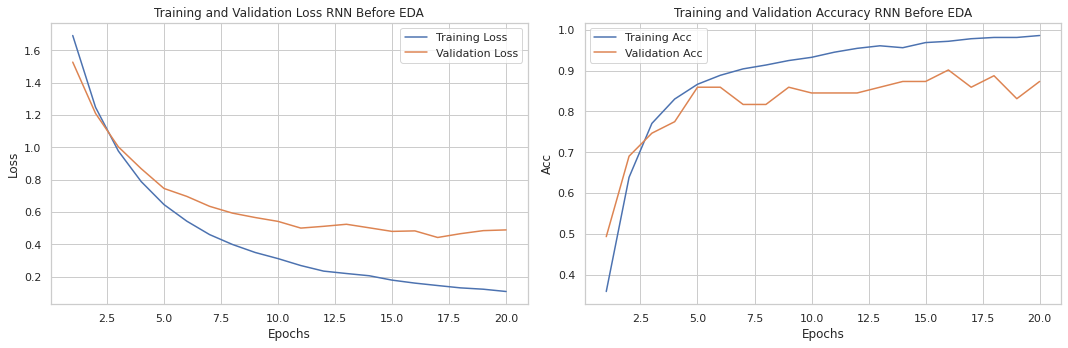

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
epochs = range(1, 21)

# Set Seaborn style
sns.set(style="whitegrid")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# First subplot: Training and Validation Loss
sns.lineplot(x=epochs, y=RNN_train_loss_before, label='Training Loss', ax=ax1)
sns.lineplot(x=epochs, y=RNN_val_loss_before, label='Validation Loss', ax=ax1)
ax1.set_title('Training and Validation Loss RNN Before EDA')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='best')

# Second subplot: Training and Validation Accuracy
sns.lineplot(x=epochs, y=RNN_train_acc_before, label='Training Acc', ax=ax2)
sns.lineplot(x=epochs, y=RNN_val_acc_before, label='Validation Acc', ax=ax2)
ax2.set_title('Training and Validation Accuracy RNN Before EDA')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Acc')
ax2.legend(loc='best')

# Adjust spacing between subplots
plt.tight_layout()

# Save the combined plot as an image file (e.g., PNG)
plt.savefig('plot/RNN/RNN_before.png')

# Show the combined plot
plt.show()


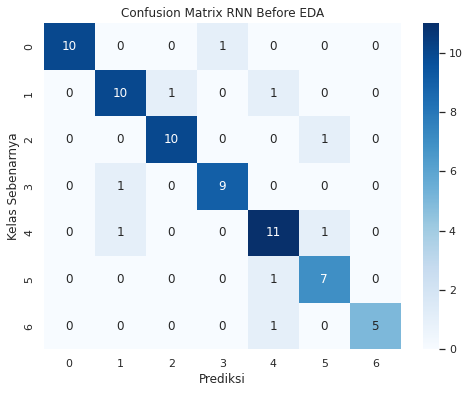

                           precision    recall  f1-score   support

    buat_reset_webhosting       1.00      0.91      0.95        11
              gagal_login       0.83      0.83      0.83        12
              masalah_vpn       0.91      0.91      0.91        11
         mengajukan_email       0.90      0.90      0.90        10
    nilai_it_tidak_keluar       0.79      0.85      0.81        13
permintaan_lisensi_office       0.78      0.88      0.82         8
      ucapan_terima_kasih       1.00      0.83      0.91         6

                 accuracy                           0.87        71
                macro avg       0.89      0.87      0.88        71
             weighted avg       0.88      0.87      0.87        71



In [170]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Set model ke mode evaluasi
RNNclassifier_before.eval()

# Inisialisasi list untuk menyimpan label sebenarnya dan prediksi
y_true = []
y_pred = []

# Loop melalui data validasi dan mengumpulkan label sebenarnya dan prediksi
with torch.no_grad():
    for inputs, labels in val_loader_before:
        outputs = RNNclassifier_before(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Menghitung confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Kelas Sebenarnya')
plt.title('Confusion Matrix RNN Before EDA')
plt.savefig('plot/RNN/confusion_matrix_before.png')
plt.show()
plt.close()

# Menampilkan laporan klasifikasi
class_names = ['buat_reset_webhosting', 'gagal_login', 'masalah_vpn', 'mengajukan_email', 'nilai_it_tidak_keluar', 'permintaan_lisensi_office', 'ucapan_terima_kasih']  # Ganti dengan nama kelas Anda
print(classification_report(y_true, y_pred, target_names=class_names))

### GRU

In [173]:
GRUclassifier_before = GRUNet(64)
GRUoptimizer_before = optim.Adam(GRUclassifier_before.parameters(), lr=0.001, weight_decay=0.00017)
GRUcriterion_before = nn.CrossEntropyLoss()

In [174]:
import time

num_epochs = 20
GRU_train_loss_before = []
GRU_train_acc_before = []
GRU_train_f1_before = []
GRU_val_loss_before = []
GRU_val_acc_before = []
GRU_val_f1_before = []

for epoch in range(num_epochs):
    epoch_start = time.time()  # Start time of the epoch

    # Training phase
    running_loss = 0.0
    running_f1 = 0.0
    correct = 0
    total = 0
    model_before.train()
    for inputs, labels in train_loader_before:
        GRUoptimizer_before.zero_grad()
        outputs = GRUclassifier_before(inputs)
        loss = GRUcriterion_before(outputs, labels.long())
        loss.backward()
        GRUoptimizer_before.step()

        _, predicted = torch.max(outputs.data, 1)
        running_f1 += multiclass_f1_score(predicted, labels, num_classes=7)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader_before)
    epoch_acc = correct / total
    epoch_f1 = running_f1 / len(train_loader_before)
    GRU_train_loss_before.append(epoch_loss)
    GRU_train_acc_before.append(epoch_acc)
    GRU_train_f1_before.append(epoch_f1)

    # Validation phase
    valid_loss = 0.0
    valid_f1 = 0.0
    correct = 0
    total = 0
    model_before.eval()
    with torch.no_grad():
        for inputs, labels in val_loader_before:
            outputs = GRUclassifier_before(inputs)
            loss = GRUcriterion_before(outputs, labels.long())

            _, predicted = torch.max(outputs.data, 1)
            valid_f1 += multiclass_f1_score(predicted, labels, num_classes=7)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            valid_loss += loss.item()

    GRU_val_loss_before.append(valid_loss / len(val_loader_before))
    GRU_val_acc_before.append(correct / total)
    GRU_val_f1_before.append(valid_f1 / len(val_loader_before))

    # Epoch end time
    epoch_end = time.time()
    epoch_duration = epoch_end - epoch_start

    # Print epoch summary
    print('Epoch [{}/{}], Time elapsed: {:.2f} s, \n\tTrain Loss: {:.4f}, Train Acc: {:.4f}, Train F1: {:.4f}'
          .format(epoch+1, num_epochs, epoch_duration, epoch_loss, epoch_acc, epoch_f1))
    print('\tVal Loss: {:.4f}, Val Acc: {:.4f}, Val F1: {:.4f}'
          .format(valid_loss / len(val_loader_before), correct / total, valid_f1 / len(val_loader_before)))

Epoch [1/20], Time elapsed: 38.41 s, 
	Train Loss: 1.7574, Train Acc: 0.3648, Train F1: 0.3650
	Val Loss: 1.5747, Val Acc: 0.5352, Val F1: 0.5446
Epoch [2/20], Time elapsed: 37.30 s, 
	Train Loss: 1.3152, Train Acc: 0.6588, Train F1: 0.6598
	Val Loss: 1.2374, Val Acc: 0.6761, Val F1: 0.6488
Epoch [3/20], Time elapsed: 41.33 s, 
	Train Loss: 0.9623, Train Acc: 0.7736, Train F1: 0.7734
	Val Loss: 1.0069, Val Acc: 0.7606, Val F1: 0.7113
Epoch [4/20], Time elapsed: 39.01 s, 
	Train Loss: 0.7444, Train Acc: 0.8302, Train F1: 0.8292
	Val Loss: 0.8709, Val Acc: 0.7746, Val F1: 0.7217
Epoch [5/20], Time elapsed: 41.20 s, 
	Train Loss: 0.5815, Train Acc: 0.8758, Train F1: 0.8752
	Val Loss: 0.7311, Val Acc: 0.7746, Val F1: 0.7217
Epoch [6/20], Time elapsed: 40.25 s, 
	Train Loss: 0.4830, Train Acc: 0.8962, Train F1: 0.8964
	Val Loss: 0.6483, Val Acc: 0.8451, Val F1: 0.7738
Epoch [7/20], Time elapsed: 45.89 s, 
	Train Loss: 0.3977, Train Acc: 0.9135, Train F1: 0.9138
	Val Loss: 0.6125, Val Acc: 0

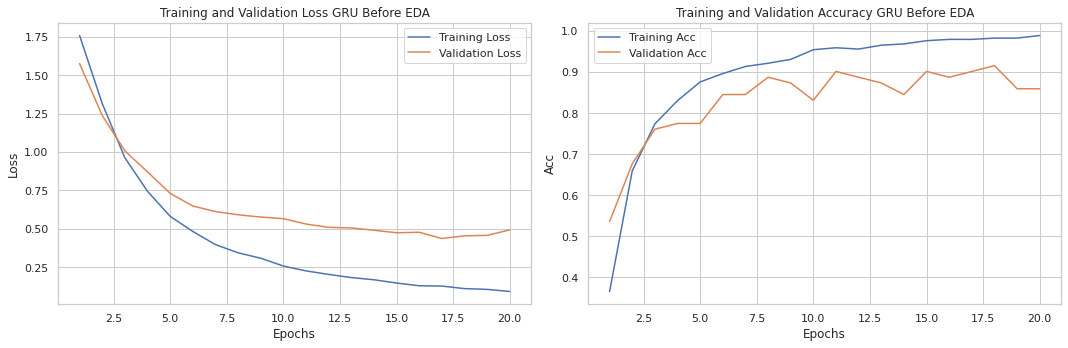

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
epochs = range(1, 21)

# Set Seaborn style
sns.set(style="whitegrid")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# First subplot: Training and Validation Loss
sns.lineplot(x=epochs, y=GRU_train_loss_before, label='Training Loss', ax=ax1)
sns.lineplot(x=epochs, y=GRU_val_loss_before, label='Validation Loss', ax=ax1)
ax1.set_title('Training and Validation Loss GRU Before EDA')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='best')

# Second subplot: Training and Validation Accuracy
sns.lineplot(x=epochs, y=GRU_train_acc_before, label='Training Acc', ax=ax2)
sns.lineplot(x=epochs, y=GRU_val_acc_before, label='Validation Acc', ax=ax2)
ax2.set_title('Training and Validation Accuracy GRU Before EDA')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Acc')
ax2.legend(loc='best')

# Adjust spacing between subplots
plt.tight_layout()

# Save the combined plot as an image file (e.g., PNG)
plt.savefig('plot/GRU/GRU_before.png')

# Show the combined plot
plt.show()


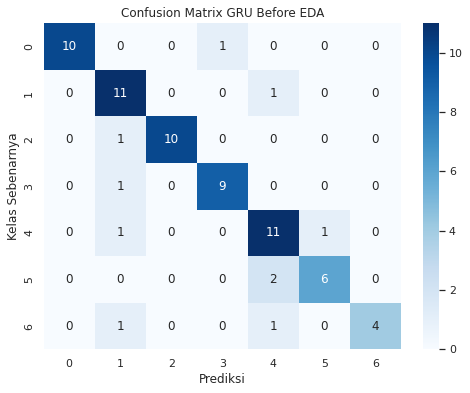

                           precision    recall  f1-score   support

    buat_reset_webhosting       1.00      0.91      0.95        11
              gagal_login       0.73      0.92      0.81        12
              masalah_vpn       1.00      0.91      0.95        11
         mengajukan_email       0.90      0.90      0.90        10
    nilai_it_tidak_keluar       0.73      0.85      0.79        13
permintaan_lisensi_office       0.86      0.75      0.80         8
      ucapan_terima_kasih       1.00      0.67      0.80         6

                 accuracy                           0.86        71
                macro avg       0.89      0.84      0.86        71
             weighted avg       0.88      0.86      0.86        71



In [171]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Set model ke mode evaluasi
GRUclassifier_before.eval()

# Inisialisasi list untuk menyimpan label sebenarnya dan prediksi
y_true = []
y_pred = []

# Loop melalui data validasi dan mengumpulkan label sebenarnya dan prediksi
with torch.no_grad():
    for inputs, labels in val_loader_before:
        outputs = GRUclassifier_before(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Menghitung confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Kelas Sebenarnya')
plt.title('Confusion Matrix GRU Before EDA')
plt.savefig('plot/GRU/confusion_matrix_before.png')
plt.show()
plt.close()

# Menampilkan laporan klasifikasi
class_names = ['buat_reset_webhosting', 'gagal_login', 'masalah_vpn', 'mengajukan_email', 'nilai_it_tidak_keluar', 'permintaan_lisensi_office', 'ucapan_terima_kasih']  # Ganti dengan nama kelas Anda
print(classification_report(y_true, y_pred, target_names=class_names))

## Compare Before And After Augmentation

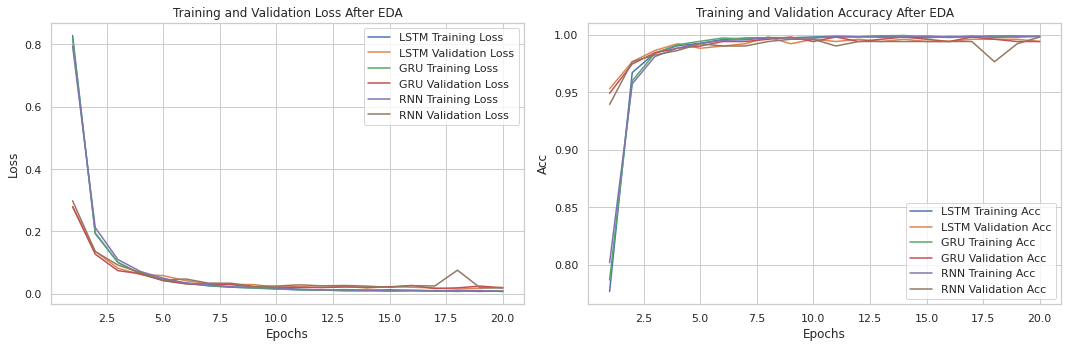

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
epochs = range(1, 21)

# Set Seaborn style
sns.set(style="whitegrid")

# Create a figure with two subplots (Loss and Accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Training and Validation Loss for LSTM
sns.lineplot(x=epochs, y=LSTM_train_loss, label='LSTM Training Loss', ax=ax1)
sns.lineplot(x=epochs, y=LSTM_val_loss, label='LSTM Validation Loss', ax=ax1)

# Plot Training and Validation Loss for GRU
sns.lineplot(x=epochs, y=GRU_train_loss, label='GRU Training Loss', ax=ax1)
sns.lineplot(x=epochs, y=GRU_val_loss, label='GRU Validation Loss', ax=ax1)

# Plot Training and Validation Loss for RNN
sns.lineplot(x=epochs, y=RNN_train_loss, label='RNN Training Loss', ax=ax1)
sns.lineplot(x=epochs, y=RNN_val_loss, label='RNN Validation Loss', ax=ax1)

ax1.set_title('Training and Validation Loss After EDA')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='best')

# Plot Training and Validation Accuracy for LSTM
sns.lineplot(x=epochs, y=LSTM_train_acc, label='LSTM Training Acc', ax=ax2)
sns.lineplot(x=epochs, y=LSTM_val_acc, label='LSTM Validation Acc', ax=ax2)

# Plot Training and Validation Accuracy for GRU
sns.lineplot(x=epochs, y=GRU_train_acc, label='GRU Training Acc', ax=ax2)
sns.lineplot(x=epochs, y=GRU_val_acc, label='GRU Validation Acc', ax=ax2)

# Plot Training and Validation Accuracy for RNN
sns.lineplot(x=epochs, y=RNN_train_acc, label='RNN Training Acc', ax=ax2)
sns.lineplot(x=epochs, y=RNN_val_acc, label='RNN Validation Acc', ax=ax2)

ax2.set_title('Training and Validation Accuracy After EDA')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Acc')
ax2.legend(loc='best')

# Adjust spacing between subplots
plt.tight_layout()

# Save the combined plot as a PNG file
plt.savefig('plot/training_validation_plot_after_eda.png')

# Show the combined plot
plt.show()


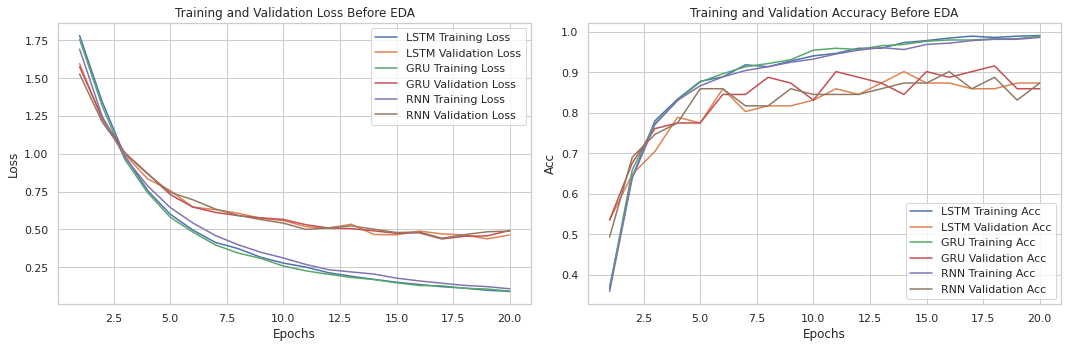

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
epochs = range(1, 21)

# Set Seaborn style
sns.set(style="whitegrid")

# Create a figure with two subplots (Loss and Accuracy) for Before EDA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Training and Validation Loss for LSTM Before EDA
sns.lineplot(x=epochs, y=LSTM_train_loss_before, label='LSTM Training Loss', ax=ax1)
sns.lineplot(x=epochs, y=LSTM_val_loss_before, label='LSTM Validation Loss', ax=ax1)

# Plot Training and Validation Loss for GRU Before EDA
sns.lineplot(x=epochs, y=GRU_train_loss_before, label='GRU Training Loss', ax=ax1)
sns.lineplot(x=epochs, y=GRU_val_loss_before, label='GRU Validation Loss', ax=ax1)

# Plot Training and Validation Loss for RNN Before EDA
sns.lineplot(x=epochs, y=RNN_train_loss_before, label='RNN Training Loss', ax=ax1)
sns.lineplot(x=epochs, y=RNN_val_loss_before, label='RNN Validation Loss', ax=ax1)

ax1.set_title('Training and Validation Loss Before EDA')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='best')

# Plot Training and Validation Accuracy for LSTM Before EDA
sns.lineplot(x=epochs, y=LSTM_train_acc_before, label='LSTM Training Acc', ax=ax2)
sns.lineplot(x=epochs, y=LSTM_val_acc_before, label='LSTM Validation Acc', ax=ax2)

# Plot Training and Validation Accuracy for GRU Before EDA
sns.lineplot(x=epochs, y=GRU_train_acc_before, label='GRU Training Acc', ax=ax2)
sns.lineplot(x=epochs, y=GRU_val_acc_before, label='GRU Validation Acc', ax=ax2)

# Plot Training and Validation Accuracy for RNN Before EDA
sns.lineplot(x=epochs, y=RNN_train_acc_before, label='RNN Training Acc', ax=ax2)
sns.lineplot(x=epochs, y=RNN_val_acc_before, label='RNN Validation Acc', ax=ax2)

ax2.set_title('Training and Validation Accuracy Before EDA')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Acc')
ax2.legend(loc='best')

# Adjust spacing between subplots
plt.tight_layout()

# Save the combined plot as a PNG file
plt.savefig('plot/training_validation_plot_before_eda.png')

# Show the combined plot for Before EDA
plt.show()
